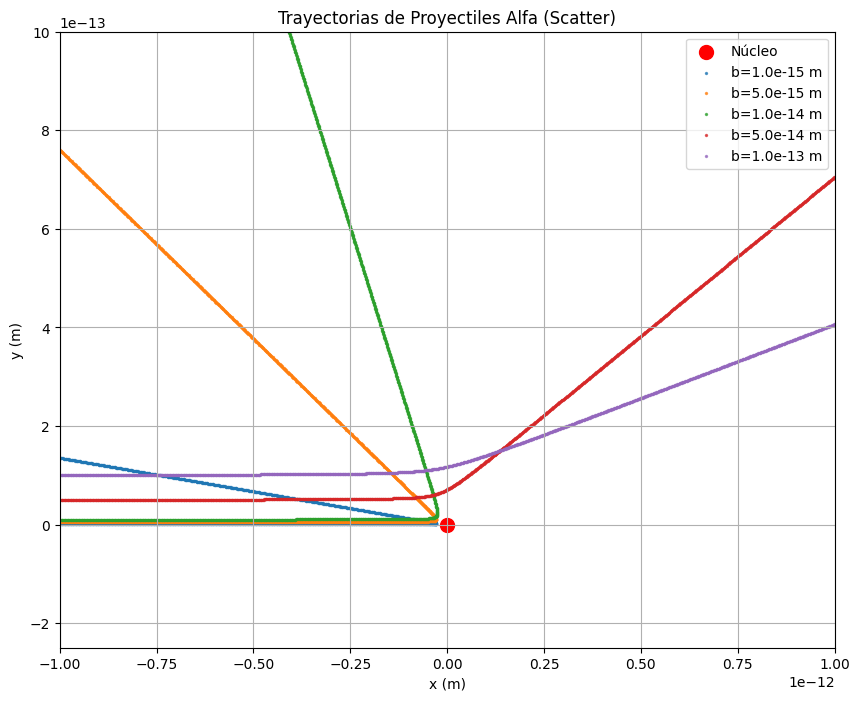

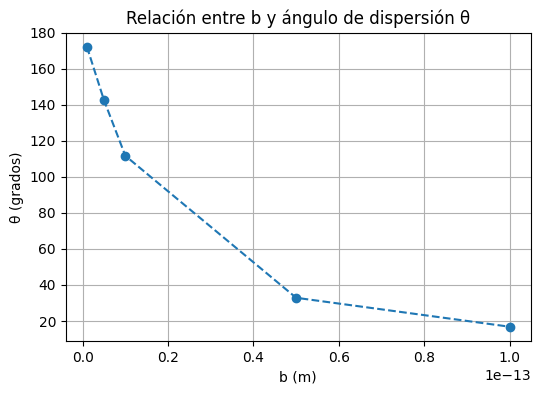

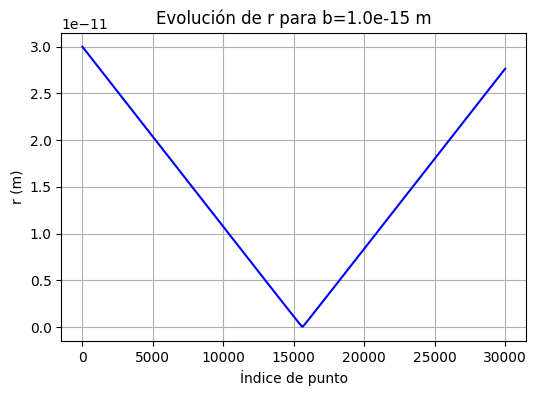

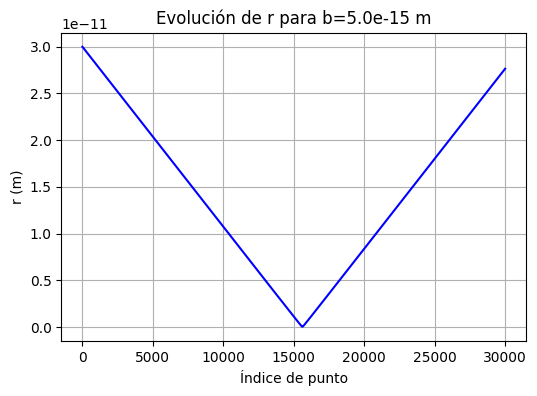

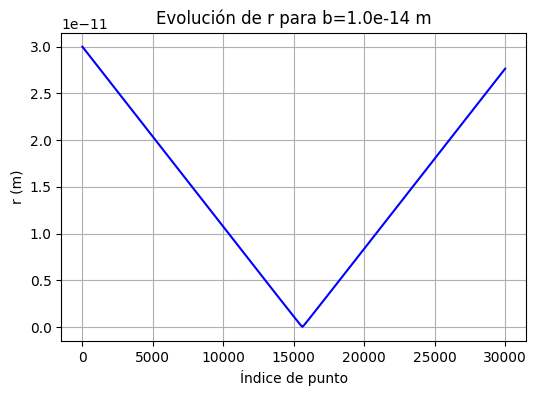

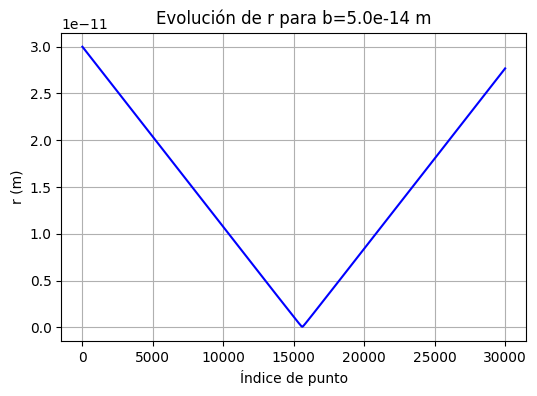

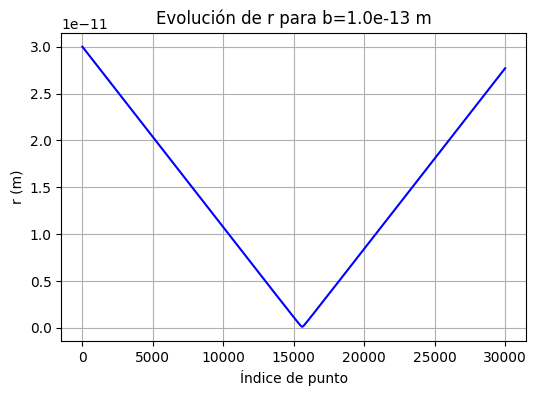

b=1.0e-15 m -> θ=172.24°, r_min=2.95e-14 m
b=5.0e-15 m -> θ=142.52°, r_min=3.03e-14 m
b=1.0e-14 m -> θ=111.68°, r_min=3.25e-14 m
b=5.0e-14 m -> θ=32.84°, r_min=6.68e-14 m
b=1.0e-13 m -> θ=16.76°, r_min=1.16e-13 m


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from numpy import pi

# Ajustamos el intervalo de tiempo y dt para la escala del problema
tiempo = np.linspace(0, 3e-18, 30000)  # Tiempo total 3e-18 s
dt = tiempo[1] - tiempo[0]             # Paso de integración

def radial_distance(location):
    return np.linalg.norm(location)

def velocity(k, alpha_mass):
    # k en MeV, se convierte a Joules (1 MeV = 1.6022e-13 J)
    energy = k * 1.6022E-13
    return np.sqrt(2.0 * energy / alpha_mass)

def coulomb_force(alpha_charge, target_charge, location, r):
    # Constante de Coulomb en unidades SI
    k_coulomb = 8.98e9
    C = k_coulomb * target_charge * alpha_charge

    x = location[0]
    y = location[1]
    F_mag = C / r**2 if r != 0 else 0
    F_x = F_mag * x / r if r != 0 else 0
    F_y = F_mag * y / r if r != 0 else 0
    return np.array([F_x, F_y])

def simulation(particle):
    history = []
    r_values = []

    for i in range(len(tiempo)):
        location = particle["location"]
        alpha_mass = particle["alpha_mass"]
        alpha_charge = particle["alpha_charge"]
        target_charge = particle["target_charge"] 
        velocity_vec = particle["velocity"]
    
        history.append(location.copy())
        r = radial_distance(location)
        r_values.append(r)

        if particle["r_min"] is None or r < particle["r_min"]:
            particle["r_min"] = r

        force = coulomb_force(alpha_charge, target_charge, location, r)
        acceleration = force / alpha_mass

        velocity_vec = velocity_vec + acceleration * dt

        location = location + velocity_vec * dt
        
        particle["location"] = location
        particle["velocity"] = velocity_vec

    particle["history"] = history
    particle["r_values"] = r_values

    vx_final = particle["velocity"][0]
    vy_final = particle["velocity"][1]
    particle["theta_dispersion"] = np.degrees(np.arctan2(vy_final, vx_final))

    return particle

def graphs(alpha_mass, alpha_charge, target_proton_num, k, bs):
    particles = []

    plt.figure(figsize=(10, 8))
    plt.title("Trayectorias de Proyectiles Alfa (Scatter)")
    plt.xlabel("x (m)")
    plt.ylabel("y (m)")
    plt.scatter([0], [0], color="red", s=100, label="Núcleo")
    plt.ylim(-0.25e-12, 1e-12)
    plt.xlim(-1e-12, 1e-12)
        
    angles = []
    minimum_dist = []
    target_charge = target_proton_num * 1.6e-19

    for b in bs:
        # Usamos una posición inicial alejada, en -1e-11 m en x
        l0 = np.array([-3e-11, b])
        v0 = np.array([velocity(k, alpha_mass), 0.0])
        particle = {
            "alpha_mass": alpha_mass,
            "alpha_charge": alpha_charge,
            "location": l0,
            "velocity": v0,
            "target_charge": target_charge,
            "r_min": None,
            "history": None
        }
        
        particle = simulation(particle)
        particles.append(particle)

        history = particle["history"]
        xs = [p[0] for p in history]
        ys = [p[1] for p in history]
        plt.scatter(xs, ys, s=2, alpha=0.7, label=f"b={b:.1e} m")

        angles.append(particle["theta_dispersion"])
        minimum_dist.append(particle["r_min"])

    plt.legend()
    plt.grid(True)
    plt.show()
    
    plt.figure(figsize=(6,4))
    plt.title("Relación entre b y ángulo de dispersión θ")
    plt.xlabel("b (m)")
    plt.ylabel("θ (grados)")
    plt.plot(bs, angles, 'o--')
    plt.grid(True)
    plt.show()

    for i, particle in enumerate(particles):
        plt.figure(figsize=(6,4))
        plt.title(f"Evolución de r para b={bs[i]:.1e} m")
        plt.xlabel("Índice de punto")
        plt.ylabel("r (m)")
        plt.plot(particle["r_values"], '-b')
        plt.grid(True)
        plt.show()

    for i, b in enumerate(bs):
        print(f"b={b:.1e} m -> θ={angles[i]:.2f}°, r_min={minimum_dist[i]:.2e} m")

# Valores para la simulación:
# Usamos una energía representativa en MeV
k = 7.7  
alpha_mass = 6.64e-27
alpha_charge = 2.0 * 1.60217662e-19
target_proton_num = 79

# Definimos un rango de bs entre 1e-15 m y 1e-13 m (5 valores)
bs = [1e-15, 5e-15, 1e-14, 5e-14, 1e-13]
graphs(alpha_mass, alpha_charge, target_proton_num, k, bs)
